# Review of SoccerCPD 

This notebook contains code for reproducing our analysis and experiments from the review of SoccerCPD
There are three parts
1. Method
2. Data
3. Experiments

## Method

### FormCPD

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from src.data import simulate_roles, simulate_swap
from src.plots import plot_delaunay, plot_adjacency_cmap
from src import FormCPD

In [5]:
F442 = np.array([
    (-40,  20), (-40,   7), (-40,  -7), (-40, -20),  
    (-10,  20), (-10,   7), (-10,  -7), (-10, -20),   
    ( 25,   8), ( 25,  -8)                            
])
F343 = np.array([
    (-40,  10), (-40,   0), (-40, -10),               
    (-10,  20), (-10,   7), (-10,  -7), (-10, -20),   
    ( 25,  18), ( 25,   0), ( 25, -18)                
])

In [11]:
V = simulate_roles(F442,F343)
A = np.array([FormCPD.delaunay_adjacency(V[t]) for t in range(len(V))])

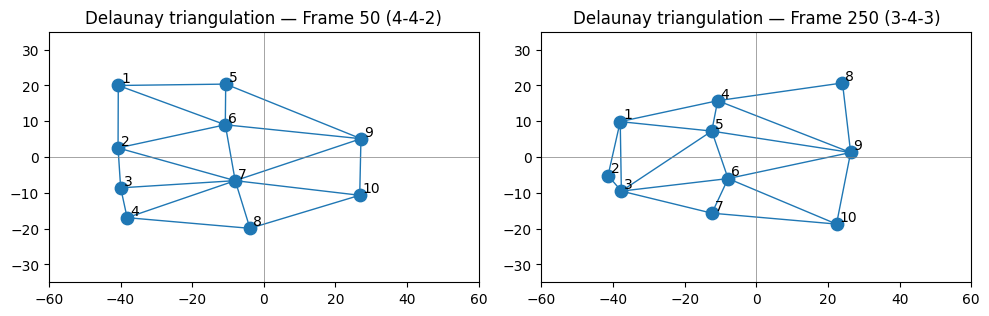

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

plot_delaunay(ax[0], V[50],  "Delaunay triangulation — Frame 50 (4-4-2)")
plot_delaunay(ax[1], V[250], "Delaunay triangulation — Frame 250 (3-4-3)")

plt.tight_layout()
# plt.savefig("report/delany_form_change.png", dpi=250)

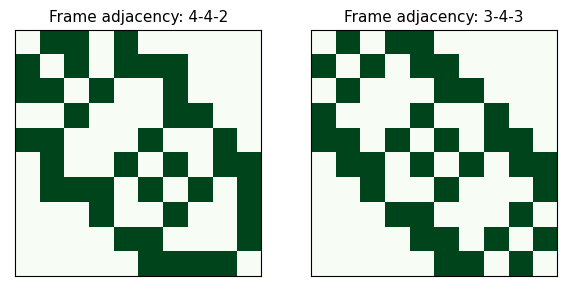

In [15]:
A_pre_frame  = A[0]
A_post_frame = A[200]
A_pre_mean   = A[:200].mean(axis=0)
A_post_mean  = A[200:].mean(axis=0)

fig1, ax1 = plt.subplots(1, 2, figsize=(7,4))
plot_adjacency_cmap(ax1[0], A_pre_frame,  "Frame adjacency: 4-4-2", cmap="Greens")
plot_adjacency_cmap(ax1[1], A_post_frame, "Frame adjacency: 3-4-3", cmap="Greens")

# plt.savefig(
#     "report/figures/A_examples.png",
#     dpi=250,
#     bbox_inches="tight",
#     pad_inches=0.02,
# )


In [17]:
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri

numpy2ri.activate()

results = FormCPD.detect_formation_changes(
    A,
    fps=1,
    alpha=0.01,
    min_minutes=1,
    min_dist=10
)

Original edge-count statistic (u): p-value approximation without skewness correction is reported.
Weighted edge-count statistic (u): p-value approximation without skewness correction is reported.
Max-type edge-count statistic (u): p-value approximation without skewness correction is reported.
Original edge-count scan statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 33.75607 
  Approximated p-value: 2.065871e-137 
Original edge-count scan statistic (u) : 
  Estimated change-point location: 200 
  Test statistic: 58.66691 
  Approximated p-value: 0 
Weighted edge-count statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 33.75607 
  Approximated p-value: 1.676847e-71 
Weighted edge-count statistic (u) : 
  Estimated change-point location: 200 
  Test statistic: 58.66691 
  Approximated p-value: 0 
Generalized edge-count statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 1151.203 
  Approximated p-value: 3.667122e-248

In [18]:
print(results)

{'change_points': [200], 'num_phases': 2, 'segments': [(0, 200), (200, 400)]}


We detect the change point at 200 !  

### Role CPD

In [5]:
from src.data import generate_synthetic_role_data
from src.RoleCPD import hamming_distance, preprocess_permutations, run_role_gseg, recursive_role_segmentation, get_dominant_perm

Total Frames: 450, Valid Frames: 450


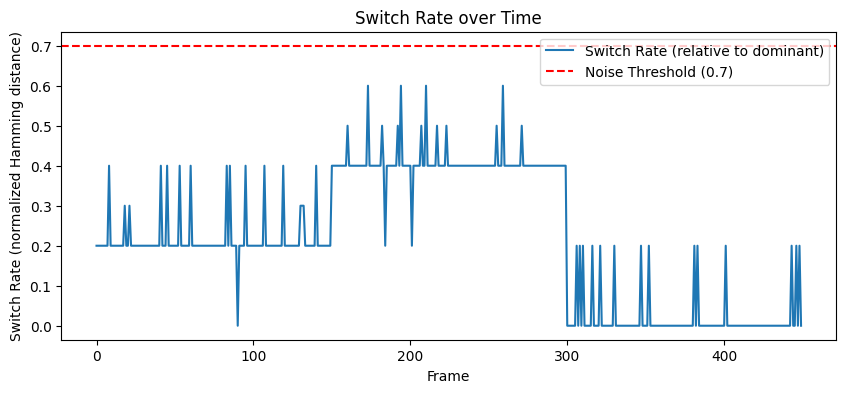

In [6]:
T, N = 450, 10
permutations = generate_synthetic_role_data(T=T, N=N, switch_times=[150, 300])

valid_idx, switch_rates = preprocess_permutations(permutations)
valid_perms = permutations[valid_idx]

print(f"Total Frames: {T}, Valid Frames: {len(valid_idx)}")
plt.figure(figsize=(10, 4))
plt.plot(switch_rates, label="Switch Rate (relative to dominant)")
plt.axhline(0.7, color='r', linestyle='--', label="Noise Threshold (0.7)")
plt.title("Switch Rate over Time")
plt.xlabel("Frame")
plt.ylabel("Switch Rate (normalized Hamming distance)")
plt.legend()
# plt.savefig("figures/RoleCPD_SwitchRate.png")

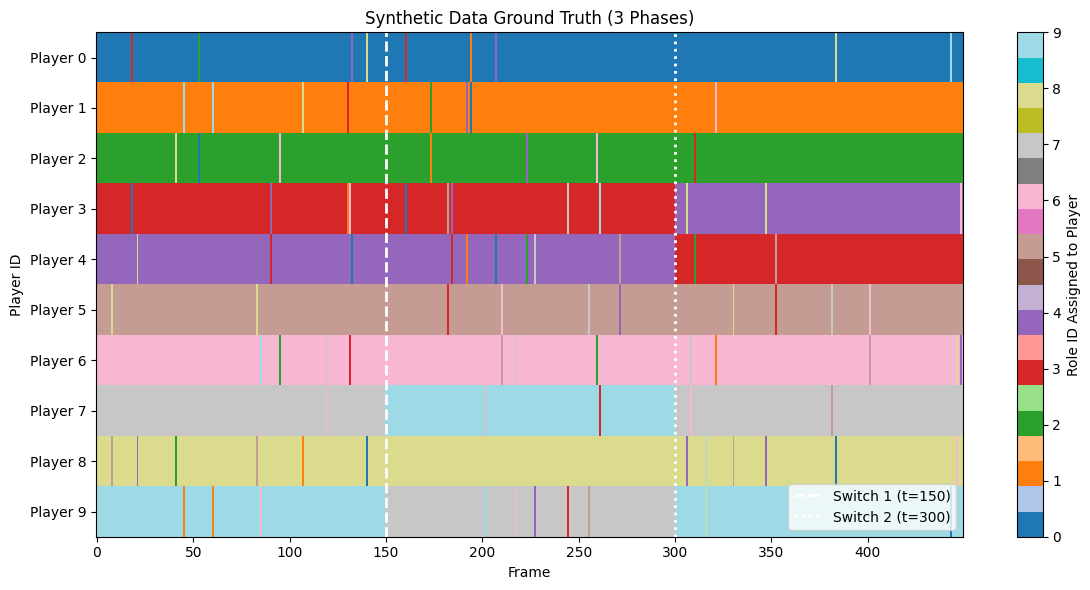

In [7]:
plt.figure(figsize=(12, 6))
plt.imshow(permutations.T, aspect='auto', cmap='tab20', interpolation='nearest')
plt.colorbar(label="Role ID Assigned to Player")
plt.xlabel("Frame")
plt.ylabel("Player ID")
plt.title("Synthetic Data Ground Truth (3 Phases)")
plt.axvline(150, color='white', linestyle='--', linewidth=2, label='Switch 1 (t=150)')
plt.axvline(300, color='white', linestyle=':', linewidth=2, label='Switch 2 (t=300)')
plt.legend(loc='lower right')
plt.yticks(np.arange(N), [f"Player {i}" for i in range(N)])
plt.tight_layout()
# plt.savefig("../figures/RoleCPD_GroundTruth.png")
# plt.show()

In [8]:
# Run detection on valid frames
tau_idx, pval = run_role_gseg(valid_perms)

# Map back to original time frame
detected_change_point = valid_idx[tau_idx]

print(f"Detected Change Point (Original Frame Index): {detected_change_point}")
print(f"P-value: {pval}")
print(f"True Change Point: {150}")

Generalized edge-count statistic (a) : 
  Estimated change-point location: 300 
  Test statistic: 11938.1 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 300 
  Test statistic: 38476.45 
  Approximated p-value: 0 
Detected Change Point (Original Frame Index): 300
P-value: 0.0
True Change Point: 150


In [9]:
detected_cps = recursive_role_segmentation(valid_perms, valid_idx, alpha=0.01, min_seg_len=50)

print("\nFinal Detected Change Points:", detected_cps)
print("True Change Points: [150, 300]")

Generalized edge-count statistic (a) : 
  Estimated change-point location: 300 
  Test statistic: 11938.1 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 300 
  Test statistic: 38476.45 
  Approximated p-value: 0 
Significant Change Detected at Frame 300 (p=0.00e+00)
Left Dominant: [0 1 2 3 4 5 6 7 8 9]
Right Dominant: [0 1 2 4 3 5 6 7 8 9]
Generalized edge-count statistic (a) : 
  Estimated change-point location: 150 
  Test statistic: 8193.737 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 150 
  Test statistic: 8575.994 
  Approximated p-value: 0 
Significant Change Detected at Frame 150 (p=0.00e+00)
Left Dominant: [0 1 2 3 4 5 6 7 8 9]
Right Dominant: [0 1 2 3 4 5 6 9 8 7]
Generalized edge-count statistic (a) : 
  Estimated change-point location: 85 
  Test statistic: 2.962265 
  Approximated p-value: 1 
Generalized edge-count statistic (u) : 
  Estimated change-point loca

R[write to console]: Error in integrate(integrandG_a, 0, 2 * pi, t = t, subdivisions = 3000,  : 
  non-finite function value

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In sqrt(varw_a) :
R[write to console]:  NaNs produced



Error running g-segmentation in R: Error in integrate(integrandG_a, 0, 2 * pi, t = t, subdivisions = 3000,  : 
  non-finite function value

Generalized edge-count statistic (a) : 
  Estimated change-point location: 48 
  Test statistic: 6.180077 
  Approximated p-value: 0.6429507 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 22 
  Test statistic: 12.12494 
  Approximated p-value: 0.05593609 

Final Detected Change Points: [150, 300]
True Change Points: [150, 300]


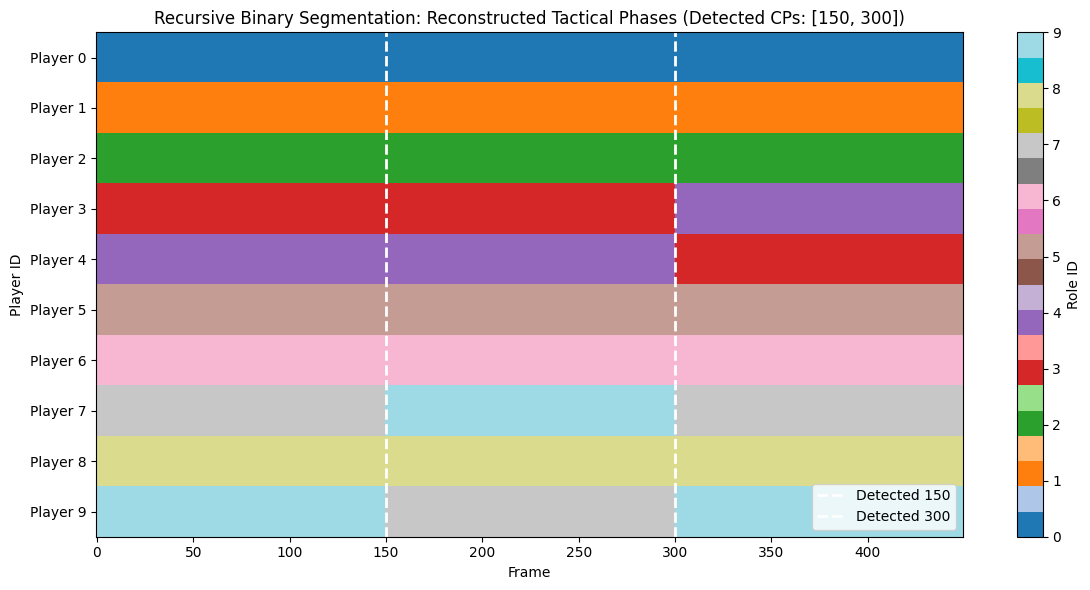

In [10]:
# Visualization of Detected Phases
plt.figure(figsize=(12, 6))

timeline_map = np.zeros((10, T)) # 10 players, T frames
boundaries = [0] + detected_cps + [T]

for i in range(len(boundaries) - 1):
    start, end = boundaries[i], boundaries[i+1]
    
    # Get permutations belonging to this interval
    mask = (valid_idx >= start) & (valid_idx < end)
    if np.any(mask):
        interval_perms = valid_perms[valid_idx[mask]]
        # Calculate dominant permutation for this specific phase
        phase_perm = get_dominant_perm(interval_perms)
    else:
        # If no valid frames in this segment (e.g. pure noise segment)
        phase_perm = np.arange(10) 
        
    # Fill timeline
    for t in range(start, end):
        timeline_map[:, t] = phase_perm

# Plotting
plt.imshow(timeline_map, aspect='auto', cmap='tab20', interpolation='nearest')
plt.colorbar(label="Role ID")
plt.title(f"Recursive Binary Segmentation: Reconstructed Tactical Phases (Detected CPs: {detected_cps})")
plt.xlabel("Frame")
plt.ylabel("Player ID")
plt.yticks(np.arange(10), [f"Player {k}" for k in range(10)])

# Draw lines for detected points
for cp in detected_cps:
    plt.axvline(cp, color='white', linestyle='--', linewidth=2, label=f'Detected {cp}')

plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig("../figures/RoleCPD_DetectedPhases.png")

## Data 

In [1]:
from scipy.stats import shapiro
from sklearn.cluster import KMeans
from statsbombpy import sb
from src.data import FitogetherDiagnosis

In [2]:
PITCH_LENGTH = 105.0  # Meters
PITCH_WIDTH = 68.0    # Meters
METRIC_X_RANGE = [-PITCH_LENGTH / 2, PITCH_LENGTH / 2]
METRIC_Y_RANGE = [-PITCH_WIDTH / 2, PITCH_WIDTH / 2]

In [3]:
# Constants & Configuration
ugp_data_path = 'data/ugp/17985.ugp'

In [4]:
# Fitogether Analysis
fitogether = FitogetherDiagnosis(data_path=ugp_data_path)
gps_data = fitogether.load_or_generate_data(PITCH_LENGTH,PITCH_WIDTH)
fitogether.diagnose_signal_quality()
fitogether.verify_gaussian_assumption()

Loading data from data/ugp/17985.ugp.

--- [Fitogether] Orientation Check ---
Player X Medians Range: -18.66 to 2.92
Orientation corrected: Team now attacks left to right.

--- [Fitogether] Signal Diagnosis ---
Completeness Check: 100.0000% available (Missing: 0.0000%)
Signal completeness is acceptable.
Jitter Analysis (Speed Std Dev) for player 1365.0: 1.18 m/s
High-frequency jitter detected (consistent with raw GPS).

--- [Fitogether] Gaussian Assumption Check ---
Testing Role Cluster #3 (N=500):
P-value (X-coord): 1.02e-10
P-value (Y-coord): 8.60e-07
Significant deviation from Normality (p < 0.05) found.


We find that the SoccerCPD data is complete with minimal missing values. We observe high-frequency jitter in the player trajectories, consistent with raw GPS data. There are significant deviations from the Gaussian assumption in player movements, as players hold positions (zones, often rectangular or irregular) and make tactical maneuvers. This indicates the need for robust modeling techniques, therefore justifies the use of the Change Point Detection (CPD) approach.

### StatsBomb

In [8]:
from src.data import StatsBombAdapter
from src.plots import generate_heatmap_comparison

In [7]:
# StatsBomb Analysis
sb_adapter = StatsBombAdapter(match_id=15946) # Barcelona Match
success = sb_adapter.fetch_and_transform(PITCH_LENGTH, PITCH_WIDTH)

sb_adapter.diagnose_sparsity()
# Create pseudo-trajectories to prove we can adapt the data
pseudo_traj = sb_adapter.construct_pseudo_trajectories(window_min=5)


--- [StatsBomb] Fetching Event Data (Match ID: 15946) ---


/home/fotis/MVA/TimeSeries/MiniProject/.venv/lib/python3.8/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(



--- [StatsBomb] Sparsity Diagnosis ---
Total Location Events: 3741
Temporal Density: 41.57 events/min (for whole team)
Per Player Density: ~1.89 events/min
Comparison: 1.89 events/min per player vs 600 frames/min in Fitogether GPS.

--- [StatsBomb] Constructing Pseudo-Trajectories (5 min windows) ---
Generated 388 pseudo-trajectory points (centroids).


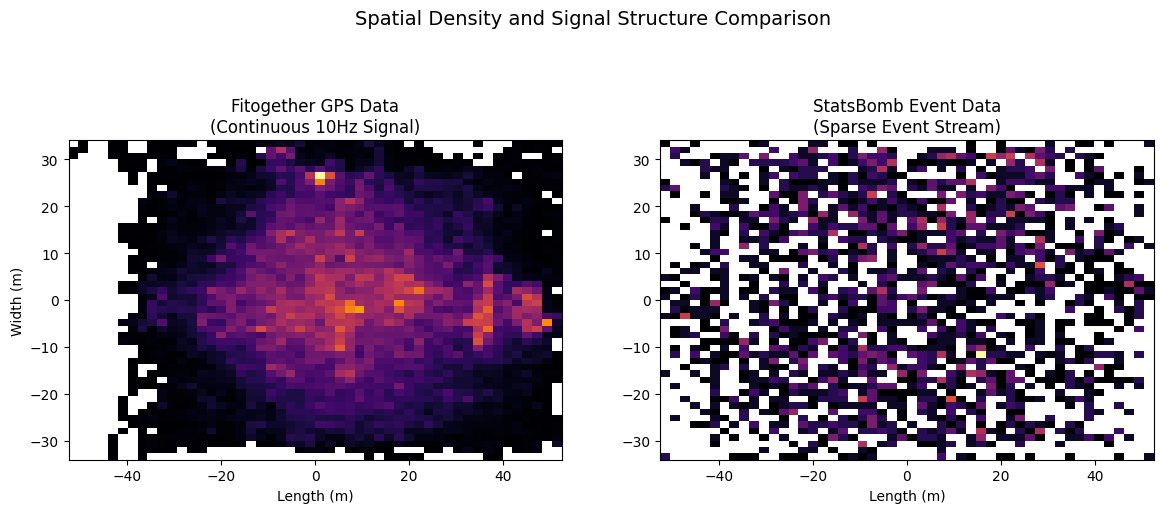

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
generate_heatmap_comparison(ax, gps_data,sb_adapter.events, METRIC_X_RANGE, METRIC_Y_RANGE)
plt.savefig("figures/data-heatmap_comparison.png")

## Experiments

### Method Sweep 

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from src.soccercpd_exp_utils import run_formcpd
from src.data import load_and_prepare_match
from src.plots import plot_method_cmap, plot_n_segments, plot_cp_timeline, plot_method_cp_timeline
from src.utils import pairwise_agreement, save_results, load_results
from soccercpd.myconstants import (
    MAX_SWITCH_RATE,
    MAX_PVAL,
    MIN_PERIOD_DUR,
    MIN_FORM_DIST,
)


In [12]:
def method_sweep(match,methods):
    results = {}

    for method in methods:
        print(f"\nRunning FormCPD with method = {method}")
        out = run_formcpd(match, formcpd_type=method)
        results[method] = out

        print(f"  → #segments = {out['n_segments']}")
        print(f"  → CPs:")
        for cp in out["change_points"]:
            print(f"     {cp}")

    return results


In [ ]:
####### UNCOMMENT TO RUN EXPERIMENT OTHERWISE LOAD ALREADY CALCULATED DATA ######


methods = [
        "gseg_avg",
        "gseg_union",
        "kernel_rbf",
        "kernel_linear"]

match = load_and_prepare_match(17985)
# results = method_sweep(match, methods)
# save_results(results, "results/method_results.pkl")
results = load_results("results/method_results.pkl")

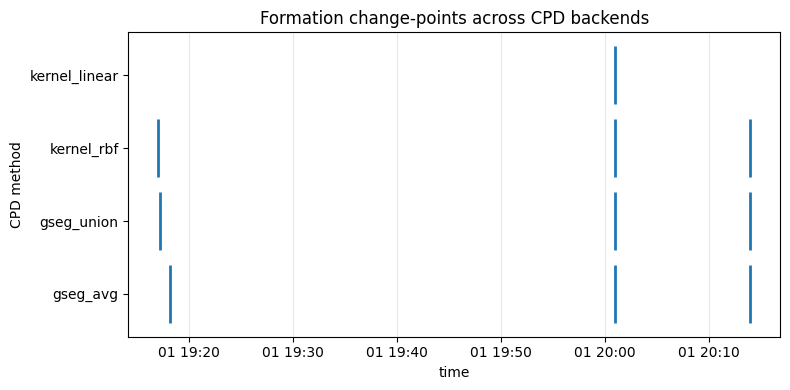

In [14]:
plot_method_cp_timeline(
    results,
    title="Formation change-points across CPD backends",
)
# plt.savefig("figures/CPD_backends.png")


### Parameter Sweep 


In [15]:
def sweep_param(
    match,
    param_name: str,
    values,
    formcpd_type: str = "gseg_avg",
    min_pdur: int = MIN_PERIOD_DUR,
    min_fdist: int = MIN_FORM_DIST,
    max_pval: float = MAX_PVAL,
):
    assert param_name in {"min_pdur", "min_fdist", "max_pval"}

    results = {}

    for v in values:
        print(f"\n[Exp2] {param_name} = {v}")

        # explicit override, no hidden kwargs
        out = run_formcpd(
            match,
            formcpd_type=formcpd_type,
            min_pdur=v if param_name == "min_pdur" else min_pdur,
            min_fdist=v if param_name == "min_fdist" else min_fdist,
            max_pval=v if param_name == "max_pval" else max_pval,
        )

        results[v] = out

        print(f"  #segments = {out['n_segments']}")
        for cp in out["change_points"]:
            print(f"    CP @ {cp}")

    return results


In [16]:
match = load_and_prepare_match(17985)

In [ ]:
####### UNCOMMENT TO RUN EXPERIMENT OTHERWISE LOAD ALREADY CALCULATED DATA ######


# res_time = sweep_param(match,param_name="min_pdur",values=[120, 300, 600])
# save_results(res_time, "results/res_time.pkl")

res_time = load_results("results/res_time.pkl")

In [22]:
####### UNCOMMENT TO RUN EXPERIMENT OTHERWISE LOAD ALREADY CALCULATED DATA ######

# res_dist = sweep_param(match,param_name="min_fdist",values=[3, 7,12])
# save_results(res_dist, "results/res_dist.pkl")

res_dist = load_results("results/res_dist.pkl")

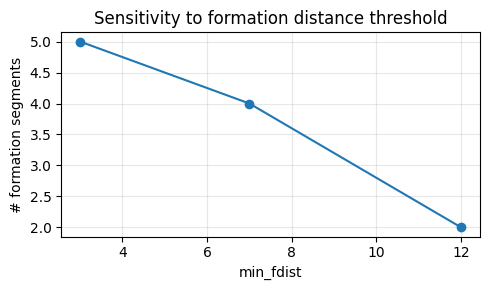

In [19]:
plot_n_segments(
    res_dist,
    xlabel="min_fdist",
    title="Sensitivity to formation distance threshold",
)


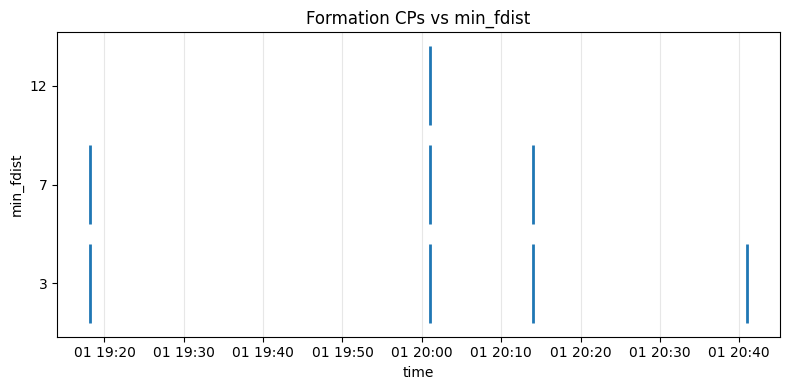

In [20]:
plot_cp_timeline(
    res_dist,
    xlabel="min_fdist",
    title="Formation CPs vs min_fdist",
)


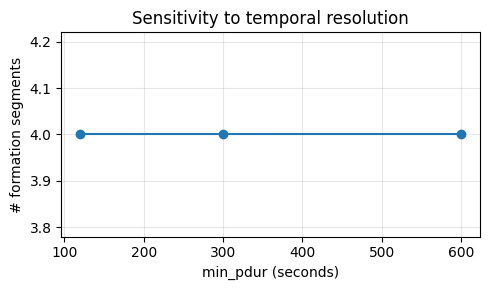

In [21]:
plot_n_segments(
    res_time,
    xlabel="min_pdur (seconds)",
    title="Sensitivity to temporal resolution",
)
